# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import os
import random
import datetime

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

# Data

In [3]:
data_path = 'https://raw.githubusercontent.com/antbartash/max_temp/master/data/data2.csv'
data = pd.read_csv(data_path, index_col=0)
data['DATE'] = data['DATE'].astype('datetime64[ns]')

print(data.shape)
data.head()

(40898, 4)


,STATION,NAME,DATE,TMAX
0,USW00012916,"NEW ORLEANS AIRPORT, LA US",2010-01-01,12.2
1,USW00012916,"NEW ORLEANS AIRPORT, LA US",2010-01-02,10.6
2,USW00012916,"NEW ORLEANS AIRPORT, LA US",2010-01-03,8.3
3,USW00012916,"NEW ORLEANS AIRPORT, LA US",2010-01-04,6.1
4,USW00012916,"NEW ORLEANS AIRPORT, LA US",2010-01-05,6.1


In [4]:
data = data[['STATION', 'DATE', 'TMAX']]

# add sine and cosine transforms to add periodicality
doy = data['DATE'].dt.dayofyear / 365.25
data['Year_sin'] = np.sin(doy * 2 * np.pi)
data['Year_cos'] = np.cos(doy * 2 * np.pi)

print(data.shape)
data.head()

(40898, 5)


,STATION,DATE,TMAX,Year_sin,Year_cos
0,USW00012916,2010-01-01,12.2,0.017202,0.999852
1,USW00012916,2010-01-02,10.6,0.034398,0.999408
2,USW00012916,2010-01-03,8.3,0.051584,0.998669
3,USW00012916,2010-01-04,6.1,0.068755,0.997634
4,USW00012916,2010-01-05,6.1,0.085906,0.996303


## Data preprocessing

In [5]:
# TRAIN/VALID/TEST SPLIT

train_df = data.loc[data['DATE'].dt.year <= 2021].reset_index(drop=True).copy()
valid_df = data.loc[data['DATE'].dt.year == 2022].reset_index(drop=True).copy()
test_df = data.loc[data['DATE'].dt.year == 2023].reset_index(drop=True).copy()

print(f'Train: {train_df.shape}')
print(f'Valid: {valid_df.shape}')
print(f'Test: {test_df.shape}')

Train: (35058, 5)
Valid: (2920, 5)
Test: (2920, 5)


In [6]:
# SCALING

train_df.drop(columns=['DATE'], inplace=True)
valid_df.drop(columns=['DATE'], inplace=True)
test_df.drop(columns=['DATE'], inplace=True)

# keep station to drop mixed windows later (encode to avoid errors from scaler)
encoder = OrdinalEncoder()
encoder.fit(train_df[['STATION']])
train_df['STATION'] = encoder.transform(train_df[['STATION']])[:, 0]
valid_df['STATION'] = encoder.transform(valid_df[['STATION']])[:, 0]
test_df['STATION'] = encoder.transform(test_df[['STATION']])[:, 0]

# scaling
scaler = StandardScaler()
scaler.fit(train_df)
train_df = pd.DataFrame(scaler.transform(train_df),
                        columns=scaler.feature_names_in_, index=train_df.index)
valid_df = pd.DataFrame(scaler.transform(valid_df),
                        columns=scaler.feature_names_in_, index=valid_df.index)
test_df = pd.DataFrame(scaler.transform(test_df),
                       columns=scaler.feature_names_in_, index=test_df.index)

train_df.head()

,STATION,TMAX,Year_sin,Year_cos
0,-1.091014,-0.747812,0.024401,1.414059
1,-1.091014,-0.896450,0.048721,1.413431
2,-1.091014,-1.110117,0.073027,1.412386
3,-1.091014,-1.314495,0.097312,1.410922
4,-1.091014,-1.314495,0.121567,1.409041


In [7]:
def tmax_inverse_transform(arr, scale=scaler.scale_[1], mean=scaler.mean_[1]):
    return arr * scale + mean

In [8]:
# TF DATASET

def create_dataset(data, target_col, source_col, seq_length):
  input_data = data[:-seq_length]
  # adding source_col to target allows to drop samples with features and target
  # from diff sources (source_col will be dropped from the target later)
  targets = data[[source_col, target_col]][seq_length:]
  dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
      input_data, targets,
      sequence_length=seq_length,
      sequence_stride=1,
      batch_size=32,
      shuffle=False,
      seed=42
    )
  for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data[:seq_length])  # First sequence: steps [0-13]
    # Corresponding target: step 14
    assert np.array_equal(targets[0, 1], data.loc[seq_length, target_col])
    break
  return dataset

train_ds = create_dataset(train_df, 'TMAX', 'STATION', 14)
valid_ds = create_dataset(valid_df, 'TMAX', 'STATION', 14)
test_ds = create_dataset(test_df, 'TMAX', 'STATION', 14)

In [9]:
# DATASET CLEANING

def filter_mixed_windows(dataset):
    def is_valid_window(inputs, targets):
        # Extract the first feature (station) from inputs and targets
        input_station_ids = inputs[:, :, 0]  # Shape: (batch_size, sequence_length)
        target_station_ids = targets[:, 0]  # Shape: (batch_size)

        # Check if all station IDs in the inputs are the same
        input_same_station = tf.reduce_all(tf.reduce_max(input_station_ids, axis=1) == tf.reduce_min(input_station_ids, axis=1))

        # Check if the target's station ID matches the input station ID
        target_matches_input = tf.reduce_all(tf.reduce_max(input_station_ids, axis=1) == target_station_ids)

        # Only keep windows where both conditions are true
        return tf.logical_and(input_same_station, target_matches_input)

    # Filter the dataset
    filtered_dataset = dataset.filter(is_valid_window)
    return filtered_dataset

train_ds = filter_mixed_windows(train_ds)
valid_ds = filter_mixed_windows(valid_ds)
test_ds = filter_mixed_windows(test_ds)

In [10]:
def drop_first_column(feature, label):
    feature = feature[:, :, 1:]  # Keep all rows, drop the first column
    label = label[:, 1:]    # Keep all rows, drop the first column
    return feature, label

train_ds = train_ds.map(drop_first_column)
valid_ds = valid_ds.map(drop_first_column)
test_ds = test_ds.map(drop_first_column)

In [11]:
def load_data(batch_size, prefetch=tf.data.AUTOTUNE,
              train_ds=train_ds, valid_ds=valid_ds, test_ds=test_ds):
    train_ds = train_ds.rebatch(batch_size).prefetch(prefetch)
    valid_ds = valid_ds.rebatch(batch_size).prefetch(prefetch)
    test_ds = test_ds.rebatch(batch_size).prefetch(prefetch)
    train_num_batches = len(list(train_ds))
    valid_num_batches = len(list(valid_ds))
    test_num_batches = len(list(test_ds))
    # print(f'load_data - num_batches (train, valid, test): {train_num_batches}, {valid_num_batches}, {test_num_batches}')
    train_ds_repeat = train_ds.repeat()
    valid_ds_repeat = valid_ds.repeat()
    test_ds_repeat = test_ds.repeat()
    return train_ds_repeat, valid_ds_repeat, test_ds_repeat, train_num_batches, valid_num_batches, test_num_batches

train_ds_repeat, valid_ds_repeat, test_ds_repeat, train_num_batches, valid_num_batches, test_num_batches = load_data(batch_size=32)

# Model

In [ ]:
INPUT_SHAPE = (14, 3, )

# tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=75, restore_best_weights=True
)

# lr scheduler
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=25
)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.SimpleRNN(4, activation='tanh', return_sequences=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='gelu'),
    tf.keras.layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer,
              metrics=['mean_squared_error'])

history = model.fit(
    train_ds_repeat, epochs=750, validation_data=valid_ds_repeat,
    steps_per_epoch=train_num_batches, validation_steps=valid_num_batches,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback],
    verbose=1
)

Epoch 1/750
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.3448 - mean_squared_error: 0.2094 - val_loss: 0.3196 - val_mean_squared_error: 0.1771 - learning_rate: 0.0010
Epoch 2/750
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2658 - mean_squared_error: 0.1332 - val_loss: 0.3179 - val_mean_squared_error: 0.1705 - learning_rate: 0.0010
Epoch 3/750
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2623 - mean_squared_error: 0.1291 - val_loss: 0.3165 - val_mean_squared_error: 0.1681 - learning_rate: 0.0010
Epoch 4/750
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2600 - mean_squared_error: 0.1269 - val_loss: 0.3144 - val_mean_squared_error: 0.1670 - learning_rate: 0.0010
Epoch 5/750
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2587 - mean_squared_error: 0.1254 - val_loss: 0.3126 - val_mean_squared_error: 0.1659 - learning_rate: 0.0010
Epoch 6/750
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.2580 - mean_squared_error: 0.1248 - val_loss: 0.3122 - val_m

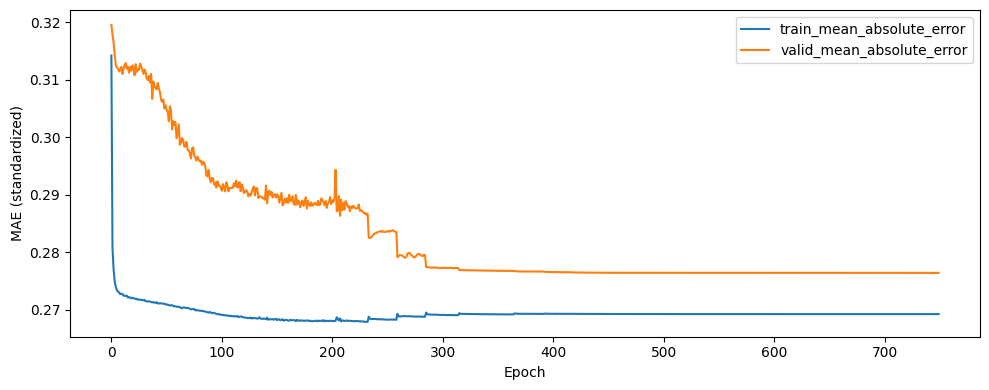

In [15]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['loss'], label='train_mean_absolute_error')
ax.plot(history.history['val_loss'], label='valid_mean_absolute_error')
ax.set_ylabel('MAE (standardized)')
ax.set_xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
y_train = np.concatenate([targets.numpy().reshape(-1) for _, targets in train_ds_repeat.take(train_num_batches)]).reshape(-1, 1)
y_valid = np.concatenate([targets.numpy().reshape(-1) for _, targets in valid_ds_repeat.take(valid_num_batches)]).reshape(-1, 1)

y_train_pred = model.predict(train_ds, steps=train_num_batches)
y_valid_pred = model.predict(valid_ds, steps=valid_num_batches)

print(f'Train MAE (standardized): {mean_absolute_error(y_train, y_train_pred)}')
print(f'Valid MAE (standardized): {mean_absolute_error(y_valid, y_valid_pred)}')

print(f'Train MAE: {mean_absolute_error(tmax_inverse_transform(y_train), tmax_inverse_transform(y_train_pred))}')
print(f'Valid MAE: {mean_absolute_error(tmax_inverse_transform(y_valid), tmax_inverse_transform(y_valid_pred))}')

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train MAE (standardized): 0.26925571331803516
Valid MAE (standardized): 0.27642598793925727
Train MAE: 2.898372343251147
Valid MAE: 2.975555997982685


## Model 1.1 - more units

In [13]:
INPUT_SHAPE = (14, 3, )

# tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=75, restore_best_weights=True
)

# lr scheduler
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=25
)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='gelu'),
    tf.keras.layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer,
              metrics=['mean_squared_error'])

history = model.fit(
    train_ds_repeat, epochs=500, validation_data=valid_ds_repeat,
    steps_per_epoch=train_num_batches, validation_steps=valid_num_batches,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback],
    verbose=2
)

Epoch 1/500
1088/1088 - 10s - 9ms/step - loss: 0.2961 - mean_squared_error: 0.1558 - val_loss: 0.3176 - val_mean_squared_error: 0.1782 - learning_rate: 0.0010
Epoch 2/500
1088/1088 - 8s - 7ms/step - loss: 0.2773 - mean_squared_error: 0.1409 - val_loss: 0.3117 - val_mean_squared_error: 0.1728 - learning_rate: 0.0010
Epoch 3/500
1088/1088 - 7s - 7ms/step - loss: 0.2752 - mean_squared_error: 0.1396 - val_loss: 0.3113 - val_mean_squared_error: 0.1736 - learning_rate: 0.0010
Epoch 4/500
1088/1088 - 7s - 7ms/step - loss: 0.2757 - mean_squared_error: 0.1402 - val_loss: 0.3098 - val_mean_squared_error: 0.1724 - learning_rate: 0.0010
Epoch 5/500
1088/1088 - 8s - 7ms/step - loss: 0.2754 - mean_squared_error: 0.1396 - val_loss: 0.3041 - val_mean_squared_error: 0.1656 - learning_rate: 0.0010
Epoch 6/500
1088/1088 - 8s - 7ms/step - loss: 0.2739 - mean_squared_error: 0.1387 - val_loss: 0.3018 - val_mean_squared_error: 0.1645 - learning_rate: 0.0010
Epoch 7/500
1088/1088 - 8s - 7ms/step - loss: 0.273

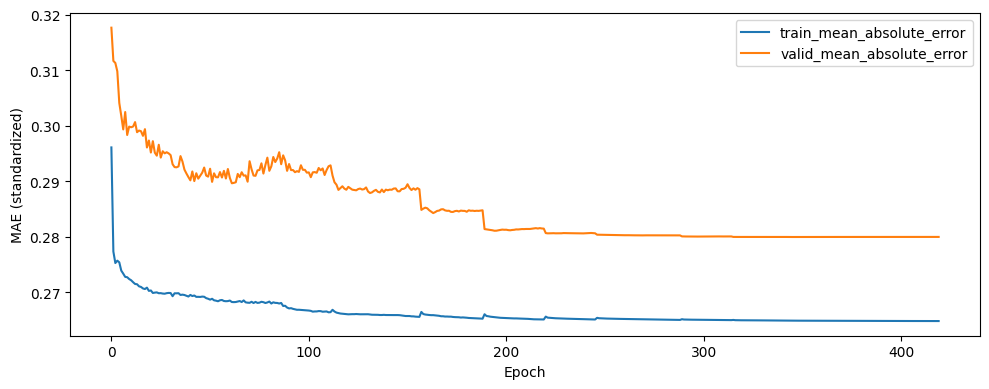

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['loss'], label='train_mean_absolute_error')
ax.plot(history.history['val_loss'], label='valid_mean_absolute_error')
ax.set_ylabel('MAE (standardized)')
ax.set_xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
y_train = np.concatenate([targets.numpy().reshape(-1) for _, targets in train_ds_repeat.take(train_num_batches)]).reshape(-1, 1)
y_valid = np.concatenate([targets.numpy().reshape(-1) for _, targets in valid_ds_repeat.take(valid_num_batches)]).reshape(-1, 1)

y_train_pred = model.predict(train_ds, steps=train_num_batches)
y_valid_pred = model.predict(valid_ds, steps=valid_num_batches)

print(f'Train MAE (standardized): {mean_absolute_error(y_train, y_train_pred)}')
print(f'Valid MAE (standardized): {mean_absolute_error(y_valid, y_valid_pred)}')

print(f'Train MAE: {mean_absolute_error(tmax_inverse_transform(y_train), tmax_inverse_transform(y_train_pred))}')
print(f'Valid MAE: {mean_absolute_error(tmax_inverse_transform(y_valid), tmax_inverse_transform(y_valid_pred))}')

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MAE (standardized): 0.2648382961604719
Valid MAE (standardized): 0.2799293490115424
Train MAE: 2.850821558523018
Valid MAE: 3.013267491959988


## Model 2 - 2 layers

In [12]:
INPUT_SHAPE = (14, 3, )

# tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=100, restore_best_weights=True
)

# lr scheduler
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=25
)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.SimpleRNN(4, activation='tanh', return_sequences=True),
    tf.keras.layers.SimpleRNN(4, activation='tanh', return_sequences=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='gelu'),
    tf.keras.layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer,
              metrics=['mean_squared_error'])

history = model.fit(
    train_ds_repeat, epochs=500, validation_data=valid_ds_repeat,
    steps_per_epoch=train_num_batches, validation_steps=valid_num_batches,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback],
    verbose=2
)

Epoch 1/500
1088/1088 - 13s - 12ms/step - loss: 0.3464 - mean_squared_error: 0.2130 - val_loss: 0.3570 - val_mean_squared_error: 0.2067 - learning_rate: 0.0010
Epoch 2/500
1088/1088 - 9s - 8ms/step - loss: 0.3023 - mean_squared_error: 0.1667 - val_loss: 0.3402 - val_mean_squared_error: 0.1883 - learning_rate: 0.0010
Epoch 3/500
1088/1088 - 9s - 9ms/step - loss: 0.2917 - mean_squared_error: 0.1560 - val_loss: 0.3293 - val_mean_squared_error: 0.1802 - learning_rate: 0.0010
Epoch 4/500
1088/1088 - 9s - 8ms/step - loss: 0.2853 - mean_squared_error: 0.1499 - val_loss: 0.3215 - val_mean_squared_error: 0.1753 - learning_rate: 0.0010
Epoch 5/500
1088/1088 - 9s - 8ms/step - loss: 0.2815 - mean_squared_error: 0.1462 - val_loss: 0.3166 - val_mean_squared_error: 0.1711 - learning_rate: 0.0010
Epoch 6/500
1088/1088 - 9s - 8ms/step - loss: 0.2790 - mean_squared_error: 0.1436 - val_loss: 0.3160 - val_mean_squared_error: 0.1704 - learning_rate: 0.0010
Epoch 7/500
1088/1088 - 9s - 9ms/step - loss: 0.27

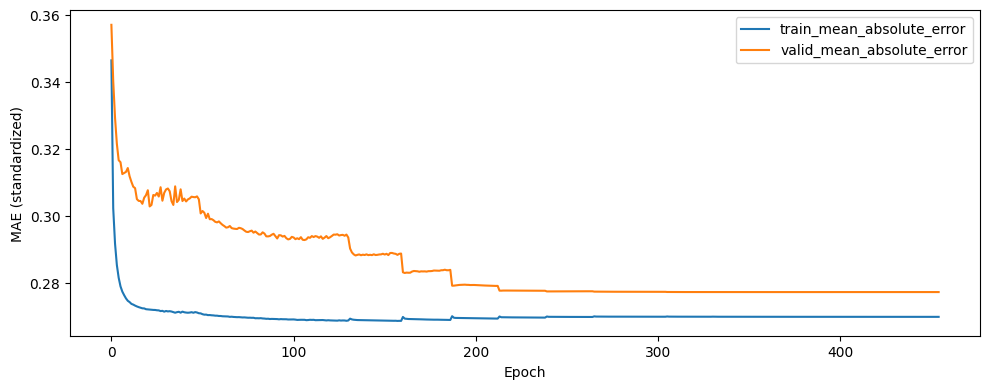

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['loss'], label='train_mean_absolute_error')
ax.plot(history.history['val_loss'], label='valid_mean_absolute_error')
ax.set_ylabel('MAE (standardized)')
ax.set_xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
y_train = np.concatenate([targets.numpy().reshape(-1) for _, targets in train_ds_repeat.take(train_num_batches)]).reshape(-1, 1)
y_valid = np.concatenate([targets.numpy().reshape(-1) for _, targets in valid_ds_repeat.take(valid_num_batches)]).reshape(-1, 1)

y_train_pred = model.predict(train_ds, steps=train_num_batches)
y_valid_pred = model.predict(valid_ds, steps=valid_num_batches)

print(f'Train MAE (standardized): {mean_absolute_error(y_train, y_train_pred)}')
print(f'Valid MAE (standardized): {mean_absolute_error(y_valid, y_valid_pred)}')

print(f'Train MAE: {mean_absolute_error(tmax_inverse_transform(y_train), tmax_inverse_transform(y_train_pred))}')
print(f'Valid MAE: {mean_absolute_error(tmax_inverse_transform(y_valid), tmax_inverse_transform(y_valid_pred))}')

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Train MAE (standardized): 0.2698956751651602
Valid MAE (standardized): 0.27726399607243263
Train MAE: 2.9052611458827946
Valid MAE: 2.984576601116656


## Model 1.2 - 8 units

In [ ]:
INPUT_SHAPE = (14, 3, )

# tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=75, restore_best_weights=True
)

# lr scheduler
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=25
)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.SimpleRNN(8, activation='tanh', return_sequences=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='gelu'),
    tf.keras.layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer,
              metrics=['mean_squared_error'])

history = model.fit(
    train_ds_repeat, epochs=750, validation_data=valid_ds_repeat,
    steps_per_epoch=train_num_batches, validation_steps=valid_num_batches,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback],
    verbose=1
)

Epoch 1/750
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.3056 - mean_squared_error: 0.1698 - val_loss: 0.3161 - val_mean_squared_error: 0.1755 - learning_rate: 0.0010
Epoch 2/750
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2602 - mean_squared_error: 0.1268 - val_loss: 0.3153 - val_mean_squared_error: 0.1731 - learning_rate: 0.0010
Epoch 3/750
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2612 - mean_squared_error: 0.1269 - val_loss: 0.3128 - val_mean_squared_error: 0.1705 - learning_rate: 0.0010
Epoch 4/750
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2594 - mean_squared_error: 0.1258 - val_loss: 0.3129 - val_mean_squared_error: 0.1702 - learning_rate: 0.0010
Epoch 5/750
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2581 - mean_squared_error: 0.1250 - val_loss: 0.3097 - val_mean_squared_error: 0.1687 - learning_rate: 0.0010
Epoch 6/750
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.2566 - mean_squared_error: 0.1243 - val_loss: 0.3064 - val_

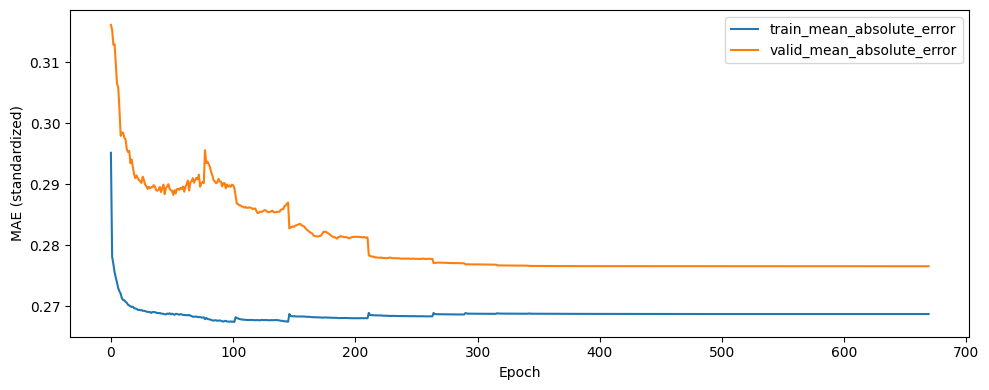

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['loss'], label='train_mean_absolute_error')
ax.plot(history.history['val_loss'], label='valid_mean_absolute_error')
ax.set_ylabel('MAE (standardized)')
ax.set_xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
y_train = np.concatenate([targets.numpy().reshape(-1) for _, targets in train_ds_repeat.take(train_num_batches)]).reshape(-1, 1)
y_valid = np.concatenate([targets.numpy().reshape(-1) for _, targets in valid_ds_repeat.take(valid_num_batches)]).reshape(-1, 1)

y_train_pred = model.predict(train_ds, steps=train_num_batches)
y_valid_pred = model.predict(valid_ds, steps=valid_num_batches)

print(f'Train MAE (standardized): {mean_absolute_error(y_train, y_train_pred)}')
print(f'Valid MAE (standardized): {mean_absolute_error(y_valid, y_valid_pred)}')

print(f'Train MAE: {mean_absolute_error(tmax_inverse_transform(y_train), tmax_inverse_transform(y_train_pred))}')
print(f'Valid MAE: {mean_absolute_error(tmax_inverse_transform(y_valid), tmax_inverse_transform(y_valid_pred))}')

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train MAE (standardized): 0.26871232002846884
Valid MAE (standardized): 0.27654227328067055
Train MAE: 2.8925230450435246
Valid MAE: 2.9768077007490885


# Model 1.3 - 2 units

In [18]:
INPUT_SHAPE = (14, 3, )

# tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=75, restore_best_weights=True
)

# lr scheduler
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=25
)


model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE),
    tf.keras.layers.SimpleRNN(2, activation='tanh', return_sequences=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='gelu'),
    tf.keras.layers.Dense(1, activation='linear')
])
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss='mean_absolute_error', optimizer=optimizer,
              metrics=['mean_squared_error'])

history = model.fit(
    train_ds_repeat, epochs=750, validation_data=valid_ds_repeat,
    steps_per_epoch=train_num_batches, validation_steps=valid_num_batches,
    callbacks=[tensorboard_callback, early_stopping_callback, lr_scheduler_callback],
    verbose=2
)

Epoch 1/750
1088/1088 - 10s - 9ms/step - loss: 0.3460 - mean_squared_error: 0.2116 - val_loss: 0.3866 - val_mean_squared_error: 0.2438 - learning_rate: 0.0010
Epoch 2/750
1088/1088 - 7s - 6ms/step - loss: 0.3024 - mean_squared_error: 0.1657 - val_loss: 0.3485 - val_mean_squared_error: 0.2023 - learning_rate: 0.0010
Epoch 3/750
1088/1088 - 6s - 6ms/step - loss: 0.2920 - mean_squared_error: 0.1567 - val_loss: 0.3328 - val_mean_squared_error: 0.1885 - learning_rate: 0.0010
Epoch 4/750
1088/1088 - 6s - 6ms/step - loss: 0.2868 - mean_squared_error: 0.1521 - val_loss: 0.3227 - val_mean_squared_error: 0.1794 - learning_rate: 0.0010
Epoch 5/750
1088/1088 - 6s - 6ms/step - loss: 0.2833 - mean_squared_error: 0.1489 - val_loss: 0.3180 - val_mean_squared_error: 0.1749 - learning_rate: 0.0010
Epoch 6/750
1088/1088 - 6s - 6ms/step - loss: 0.2808 - mean_squared_error: 0.1465 - val_loss: 0.3129 - val_mean_squared_error: 0.1702 - learning_rate: 0.0010
Epoch 7/750
1088/1088 - 6s - 6ms/step - loss: 0.278

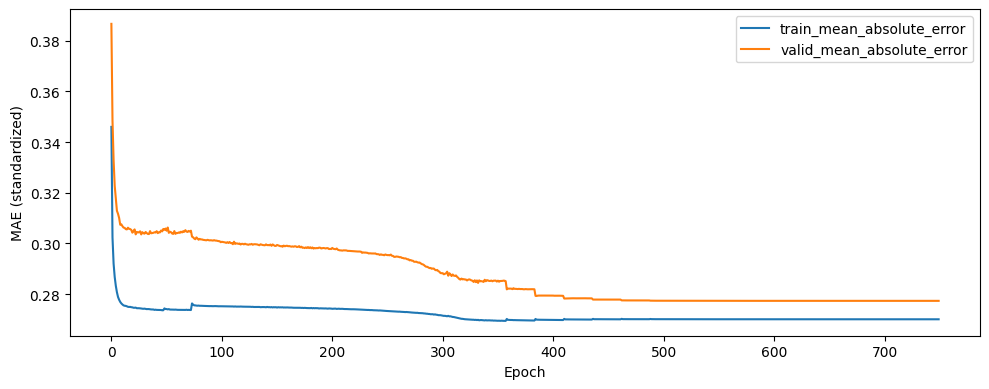

In [19]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(history.history['loss'], label='train_mean_absolute_error')
ax.plot(history.history['val_loss'], label='valid_mean_absolute_error')
ax.set_ylabel('MAE (standardized)')
ax.set_xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
y_train = np.concatenate([targets.numpy().reshape(-1) for _, targets in train_ds_repeat.take(train_num_batches)]).reshape(-1, 1)
y_valid = np.concatenate([targets.numpy().reshape(-1) for _, targets in valid_ds_repeat.take(valid_num_batches)]).reshape(-1, 1)

y_train_pred = model.predict(train_ds, steps=train_num_batches)
y_valid_pred = model.predict(valid_ds, steps=valid_num_batches)

print(f'Train MAE (standardized): {mean_absolute_error(y_train, y_train_pred)}')
print(f'Valid MAE (standardized): {mean_absolute_error(y_valid, y_valid_pred)}')

print(f'Train MAE: {mean_absolute_error(tmax_inverse_transform(y_train), tmax_inverse_transform(y_train_pred))}')
print(f'Valid MAE: {mean_absolute_error(tmax_inverse_transform(y_valid), tmax_inverse_transform(y_valid_pred))}')

1088/1088 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Train MAE (standardized): 0.2700880577458417
Valid MAE (standardized): 0.2773595657408538
Train MAE: 2.9073320140669296
Valid MAE: 2.985605357289083
